### Task 6: Individual Root Segmentation

In [4]:
#Imports
import os
import shutil
import numpy as np
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf # type: ignore
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import classification_report
from keras import backend as K
from keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

This is the first try to divide the image into five separate by drawing lines between every section: 

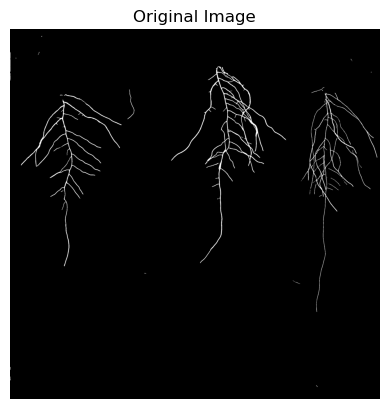

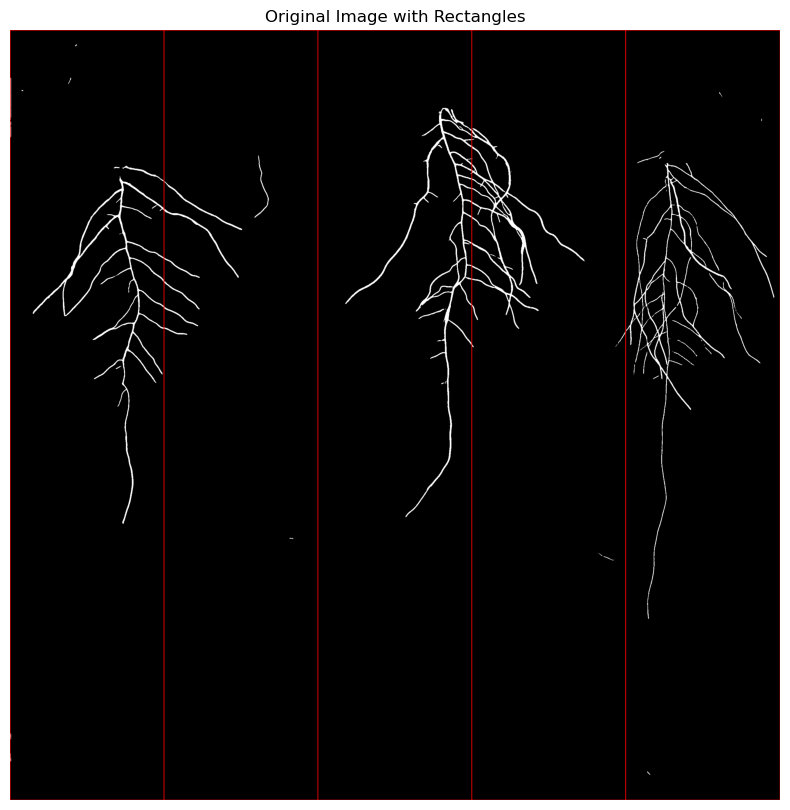

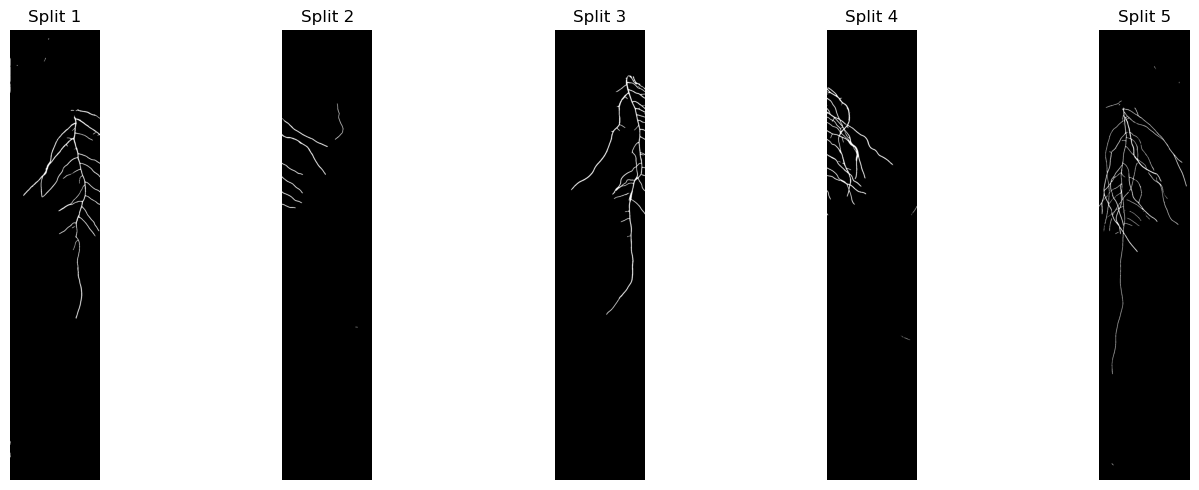

In [5]:
# reading the image
image_path = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\datalab_tasks\task5\task5_test_image_prediction_victoria_233182_RETAKE.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# displaying the image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()
# getting the dimensions of the image
height, width, _ = image.shape

# dividing the image into five equal parts vertically
part_width = width // 5

#  a list to store the image parts
image_parts_vertical = []


# drawing rectangles on the original image to mark the divided parts
image_with_rectangles = image.copy()
for i in range(5):
    start_col = i * part_width
    end_col = (i + 1) * part_width if i < 4 else width
    cv2.rectangle(image_with_rectangles, (start_col, 0), (end_col, height), (255, 0, 0), 2)

# plotting the image with rectangles
plt.figure(figsize=(10, 10))
plt.imshow(image_with_rectangles)
plt.title('Original Image with Rectangles')
plt.axis('off')
plt.show()

# plotting the image parts
for idx, part in enumerate(image_parts_vertical):
    plt.figure(figsize=(10, 10))
    plt.imshow(part)
    plt.title(f'Image Part {idx + 1} (Vertical)')
    plt.axis('off')
    plt.show()
    # drawing rectangles on the original image to mark the divided parts with thicker lines
    image_with_rectangles = image.copy()
    for i in range(5):
        start_col = i * part_width
        end_col = (i + 1) * part_width if i < 4 else width
        cv2.rectangle(image_with_rectangles, (start_col, 0), (end_col, height), (255, 0, 0), 5)  # Increased thickness to 5
        # spliting the mask into 5 equal parts
        split_masks = []
        split_width = width // 5

    # displaying the image with rectangles
    plt.imshow(image_with_rectangles)
    plt.title('Original Image with Rectangles')
    plt.axis('off')
    plt.show()
    # drawing again rectangles on the original image to mark the divided parts
    image_with_rectangles = image.copy()
    for i in range(5):
        start_col = i * part_width
        end_col = (i + 1) * part_width if i < 4 else width
        cv2.rectangle(image_with_rectangles, (start_col, 0), (end_col, height), (255, 0, 0), 2)

    # displaying the image with rectangles
    plt.imshow(image_with_rectangles)
    plt.title('Original Image with Rectangles')
    plt.axis('off')
    plt.show()


# defining split_width based on the width of the image
split_width = width // 5

# calculating the width of each split part
split_width = width // 5

# creating a list to store the 5 parts
split_masks = []

# splitting the mask into 5 equal parts
for i in range(5):
    start_x = i * split_width
    end_x = (
        (i + 1) * split_width if i < 4 else width
    )  # Ensuring that the last part extends to the end of the image
    split_mask = image[:, start_x:end_x]
    split_masks.append(split_mask)

# displaying the split masks
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, split_mask in enumerate(split_masks):
    axes[i].imshow(split_mask, cmap="gray")
    axes[i].set_title(f"Split {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

This step will be to find only the roots by drawing a bounding boxes around them in the image: 

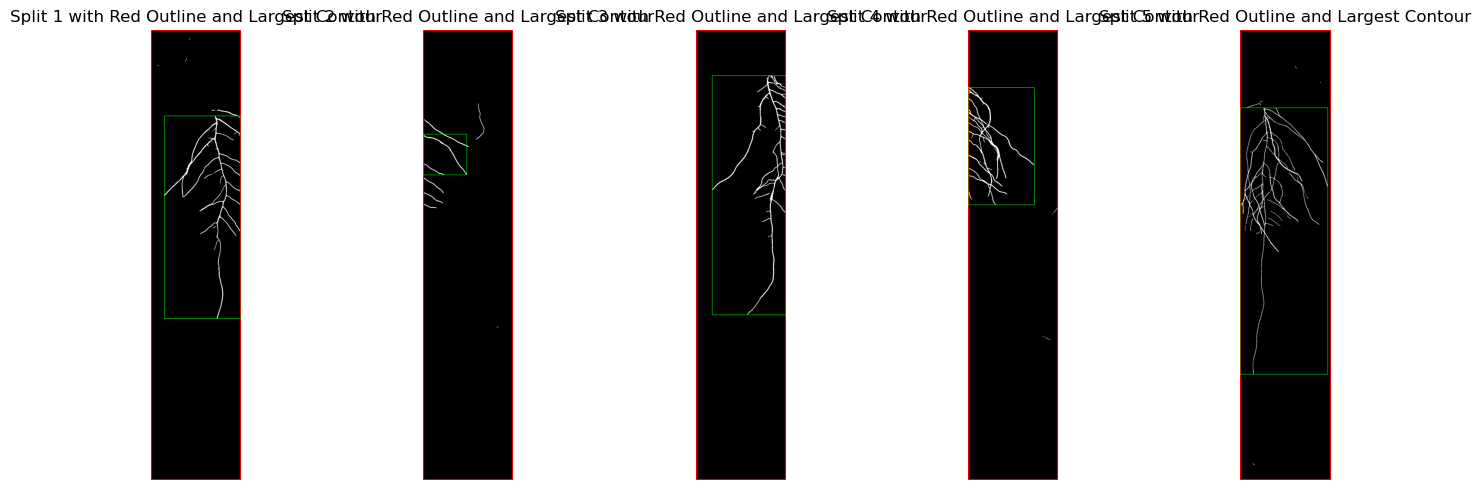

In [6]:
mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#getting the height and width of the mask
height, width = mask.shape

#dividing the image into five equal parts vertically
part_width = width // 5

#creating a list to store the image parts
image_parts_vertical = []

# splitting the mask into 5 parts
for i in range(5):
    start_col = i * part_width
    end_col = (
        (i + 1) * part_width if i < 4 else width
    )  # ensuring the last part gets the remaining width
    part = mask[:, start_col:end_col]
    image_parts_vertical.append(part)

# creating a figure to display results
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# processing each split image
for i, part in enumerate(image_parts_vertical):
    # converting the part to BGR (3 channels) to apply the red outline
    part_colored = cv2.cvtColor(part, cv2.COLOR_GRAY2BGR)

    # drawing a red outline around the entire part (thicker rectangle)
    cv2.rectangle(
        part_colored,
        (0, 0),
        (part_colored.shape[1] - 1, part_colored.shape[0] - 1),
        (0, 0, 255),
        10,
    )

    # finding contours in the split mask
    contours, _ = cv2.findContours(part, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # checking if any contours are found
    if contours:
        # finding the largest contour based on the area
        largest_contour = max(contours, key=cv2.contourArea)

        # getting the bounding box for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # drawing the bounding box for the largest contour in green
        cv2.rectangle(part_colored, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # plottting the part with the red outline and largest contour bounding box
    axes[i].imshow(cv2.cvtColor(part_colored, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Split {i+1} with Red Outline and Largest Contour")
    axes[i].axis("off")

# adjusting layout and display
plt.tight_layout()
plt.show()

Here I will try to segment the roots that above were detected in the bounding boxes: 

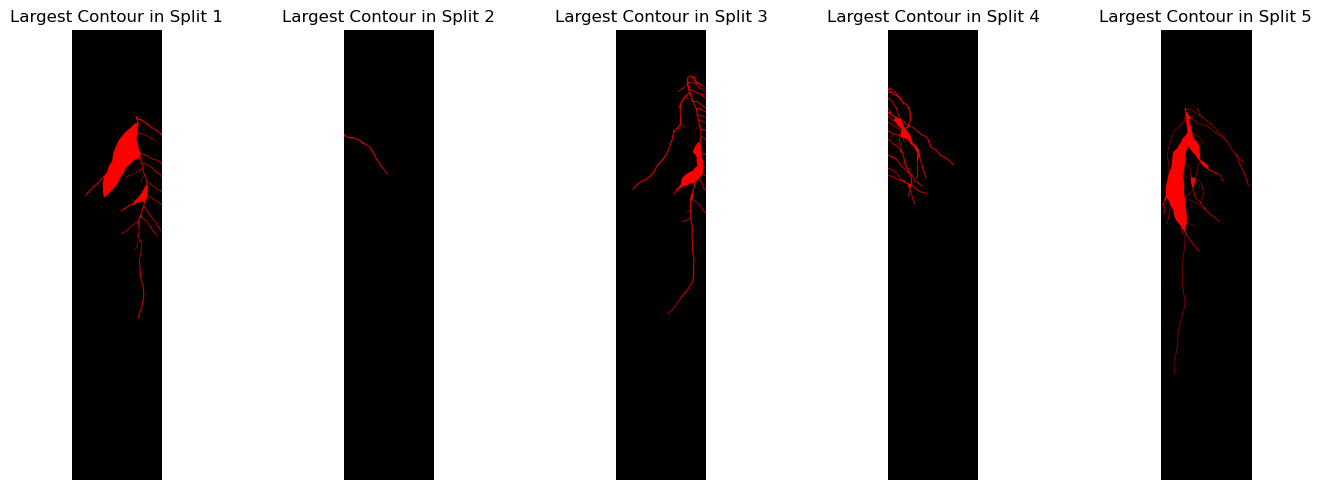

In [7]:
mask = cv2.imread(image_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# getting the dimensions of the mask
height, width, _ = mask.shape

# dividing the image into five equal parts vertically
part_width = width // 5

# creating a list to store the image parts
image_parts_vertical = []

# splitting the mask into 5 parts
for i in range(5):
    start_col = i * part_width
    end_col = (
        (i + 1) * part_width if i < 4 else width
    )  # ensuring the last part gets the remaining width
    part = mask[:, start_col:end_col]
    image_parts_vertical.append(part)

# creating a figure to display results
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# processing each split image
for i, part in enumerate(image_parts_vertical):
    # converting the part from RGB to BGR (to handle color images in OpenCV)
    part_colored = cv2.cvtColor(part, cv2.COLOR_RGB2BGR)

    # converting to grayscale for contour detection
    part_gray = cv2.cvtColor(part, cv2.COLOR_RGB2GRAY)

    # finding contours in the grayscale split mask
    contours, _ = cv2.findContours(
        part_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # creating a blank image to show only the largest contour
    largest_contour_image = np.zeros_like(part_colored)

    # cehcking if any contours are found
    if contours:
        # finding the largest contour based on the area
        largest_contour = max(contours, key=cv2.contourArea)

        # getting the bounding box for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # drawing the largest contour on the blank image in red
        cv2.drawContours(
            largest_contour_image,
            [largest_contour],
            -1,
            (0, 0, 255),
            thickness=cv2.FILLED,
        )

    # plotting the largest contour (isolated)
    axes[i].imshow(cv2.cvtColor(largest_contour_image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Largest Contour in Split {i+1}")
    axes[i].axis("off")

# adjusting layout and display
plt.tight_layout()
plt.show()

Saved processed split image as split_1_processed.png
Saved processed split image as split_2_processed.png
Saved processed split image as split_3_processed.png
Saved processed split image as split_4_processed.png
Saved processed split image as split_5_processed.png


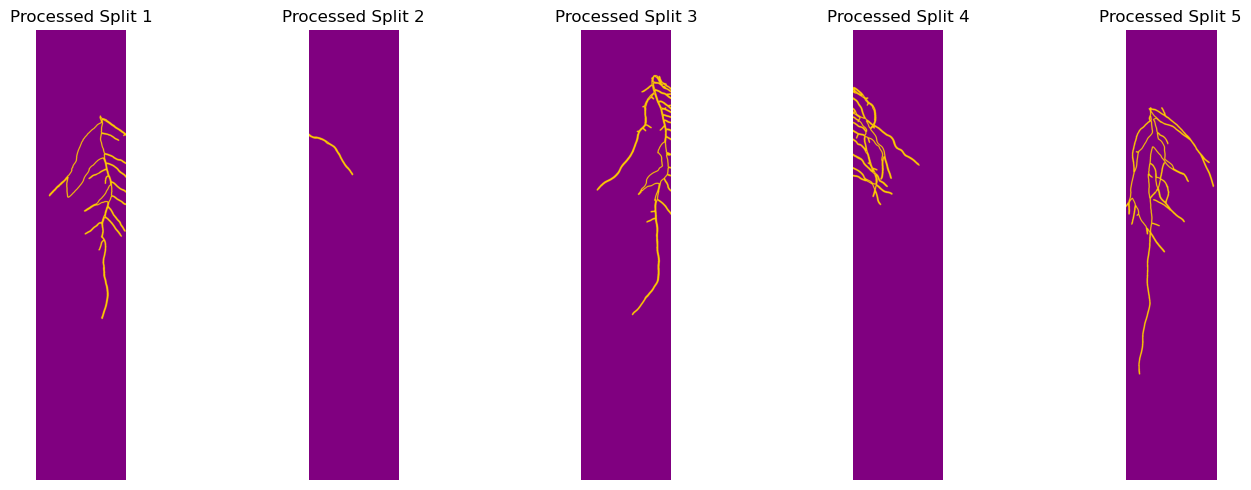

In [8]:
mask = cv2.imread(image_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# getting the dimensions of the mask
height, width, _ = mask.shape

# dividing the image into five equal parts vertically
part_width = width // 5

# creating a list to store the image parts
image_parts_vertical = []

# splitting the mask into 5 parts
for i in range(5):
    start_col = i * part_width
    end_col = (i + 1) * part_width if i < 4 else width
    part = mask[:, start_col:end_col]
    image_parts_vertical.append(part)

# defining the minimum area threshold
min_area_threshold = 1800
# processing each split image and save the result
for i, part in enumerate(image_parts_vertical):
    # convreting the part from RGB to BGR (to handle color images in OpenCV)
    part_colored = cv2.cvtColor(part, cv2.COLOR_RGB2BGR)

    # converting to grayscale for contour detection
    part_gray = cv2.cvtColor(part, cv2.COLOR_RGB2GRAY)

    # applying thresholding to get a binary mask of the roots
    _, binary_mask = cv2.threshold(part_gray, 127, 255, cv2.THRESH_BINARY)

    # finding contours in the binary mask
    contours, _ = cv2.findContours(
        binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # creating a blank image with purple background
    purple_background = np.full_like(part_colored, (128, 0, 128), dtype=np.uint8)

    # checking if any contours are found
    if contours:
        # looping through all contours and filter by area threshold
        for contour in contours:
            contour_area = cv2.contourArea(contour)
            if contour_area > min_area_threshold:
                #setting a contour on the image with yellow color
                cv2.drawContours(
                    purple_background, [contour], -1, (102, 0, 153), thickness=5
                )
                # setting a contour on the image with deep purple color
                cv2.drawContours(
                    purple_background, [contour], -1,(255, 204, 0), thickness=5
                )
    # saving the processed split image with purple background and yellow contours
    save_path = f"split_{i+1}_processed.png"
    cv2.imwrite(save_path, cv2.cvtColor(purple_background, cv2.COLOR_BGR2RGB))

    print(f"Saved processed split image as {save_path}")

# displaying the result with the processed images (optional)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, part in enumerate(image_parts_vertical):
    # Lloading the saved processed image
    processed_image = cv2.imread(f"split_{i+1}_processed.png")

    # displaying the processed image
    axes[i].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Processed Split {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()